In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import model_selection
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import linear_model
import time 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier


/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
app_events = pd.read_csv('app_events_smaller.csv')
app_labels = pd.read_csv('app_labels_smaller_a.csv')
events = pd.read_csv('events_smaller.csv')
gender_age_test = pd.read_csv('gender_age_test_smaller.csv')
gender_age_train = pd.read_csv('gender_age_train_smaller.csv')
label_categories = pd.read_csv('label_categories.csv')
phone_brand_device_model = pd.read_csv('phone_brand_device_model.csv')

In [3]:
print('Training dataset header:')
display(gender_age_train.head())
print('Dataset shape:', gender_age_train.shape)
print('')
print('Events dataset header:')
display(events.head())
print('Dataset shape:', events.shape)
print('')
print('App events dataset header:')
display(app_events.head())
print('Dataset shape:', app_events.shape)
print('')
print('App labels dataset header:')
display(app_labels.head())
print('Dataset shape:', app_labels.shape)
print('')
print('Label categories dataset header:')
display(label_categories.head())
print('Dataset shape:', label_categories.shape)
print('')
print('Phone brand & device model dataset header:')
display(phone_brand_device_model.head())
print('Dataset shape:', phone_brand_device_model.shape)

Training dataset header:


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


Dataset shape: (800, 4)

Events dataset header:


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


Dataset shape: (30000, 5)

App events dataset header:


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


Dataset shape: (300000, 4)

App labels dataset header:


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


Dataset shape: (4500, 2)

Label categories dataset header:


,label_id,category,label_itunes_id
0,1,NaN,26
1,2,game-game type,8
2,3,game-Game themes,8
3,4,game-Art Style,8
4,5,game-Leisure time,8


Dataset shape: (930, 3)

Phone brand & device model dataset header:


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


Dataset shape: (187245, 3)


In [4]:
app_events.shape

(300000, 4)

In [5]:
app_events_cleaned = app_events.drop_duplicates()

In [6]:
app_events.shape

(300000, 4)

In [7]:
app_events.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


### Most apps intalled

In [8]:
app_events_installed = (app_events
      .groupby('app_id')
      .is_installed.agg({'Sum_Installed': np.sum}))

/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


In [9]:
app_events_installed.sort_values(by='Sum_Installed', ascending=False, inplace=True)

In [10]:
app_events_installed.head()

,Sum_Installed
app_id,
8693964245073640147,10484
5927333115845830913,8198
4348659952760821294,7334
628020936226491308,5674
3433289601737013244,3412


/home/mache/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


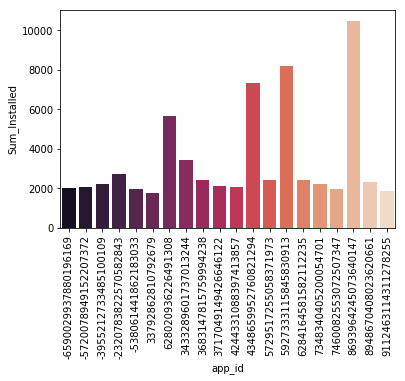

In [11]:
app_events_installed_barplot = sns.barplot(x=app_events_installed[0:20].index, 
                                           y=app_events_installed.Sum_Installed[0:20], 
                                           data=app_events_installed, palette="rocket")

app_events_installed_barplot.set_xticklabels(app_events_installed_barplot.get_xticklabels(), rotation=90)
plt.show()

In [12]:
app_events.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


### Most active apps

In [13]:
app_events_active = (app_events
                     .groupby('app_id')
                     .is_active.agg({'Is_Active': np.sum}))

/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


In [14]:
app_events_active.sort_values(by='Is_Active', ascending=False, inplace=True)

In [15]:
app_events_active.head()

,Is_Active
app_id,
8693964245073640147,8350
5927333115845830913,5614
4348659952760821294,3842
3433289601737013244,3412
628020936226491308,3155


/home/mache/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


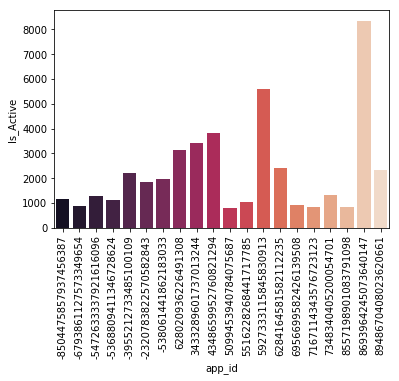

In [16]:
app_events_active_barplot = sns.barplot(x=app_events_active[0:20].index, 
                                        y=app_events_active.Is_Active[0:20], 
                                        data=app_events_active, 
                                        palette="rocket")

app_events_active_barplot.set_xticklabels(app_events_active_barplot.get_xticklabels(), rotation=90)
plt.show()

### Exploring gender and age

In [17]:
gender_age_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [18]:
gender_age_train.device_id.describe()

count    8.000000e+02
mean     1.870455e+17
std      5.441497e+18
min     -9.216966e+18
25%     -4.781568e+18
50%      1.894887e+17
75%      5.109201e+18
max      9.219480e+18
Name: device_id, dtype: float64

In [19]:
gender_age_train.shape

(800, 4)

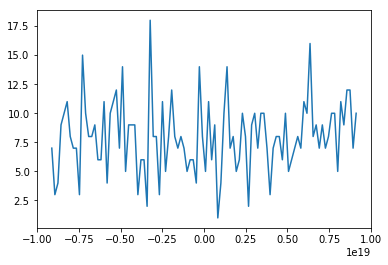

In [20]:
y,binEdges=np.histogram(gender_age_train.device_id,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-')
plt.show()

#### Gender distribution

M    540
F    260
Name: gender, dtype: int64


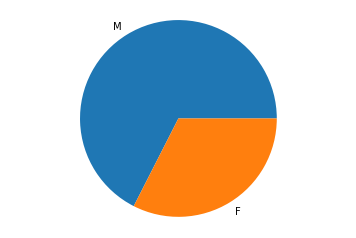

In [21]:
counts = gender_age_train.gender.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

count    800.000000
mean      31.222500
std        8.647339
min       17.000000
25%       25.000000
50%       29.000000
75%       35.000000
max       78.000000
Name: age, dtype: float64


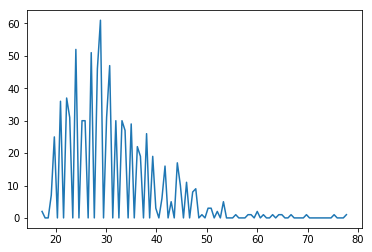

In [22]:
print(gender_age_train.age.describe())

y,binEdges=np.histogram(gender_age_train.age,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-')
plt.show()

#### Age distribution

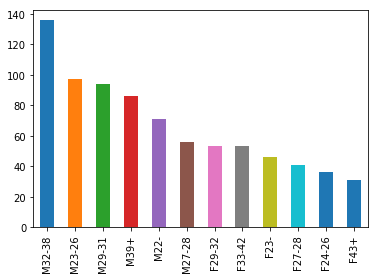

In [23]:
gender_age_train.group.value_counts().plot(kind='bar')

### Exploring test dataset

In [24]:
gender_age_test.head()

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


In [25]:
gender_age_test.shape

(1200, 1)

### Exploring categories dataset

In [26]:
label_categories_mapping = pd.read_csv('label_categories_mapping.csv')
display(label_categories_mapping.head())

,label_itunes_id,label_itunes_category
0,1,Books
1,2,Business
2,3,Catalogs
3,4,Education
4,5,Entertainment


### Combining App/Categories Data

In [27]:
app_labels.head()

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [28]:
app_label_categories = pd.merge(app_labels, label_categories, left_on='label_id', right_on='label_id')

In [29]:
app_label_categories.set_index('label_id', inplace=True)

In [30]:
app_label_categories.head()

,app_id,category,label_itunes_id
label_id,,,
251,7324884708820027918,Finance,6
251,-4494216993218550286,Finance,6
251,8756705988821000489,Finance,6
251,1061207043315821111,Finance,6
251,-1491198667294647703,Finance,6


In [31]:
label_categories_mapping = pd.read_csv('label_categories_mapping.csv')
label_categories_mapping.head()

,label_itunes_id,label_itunes_category
0,1,Books
1,2,Business
2,3,Catalogs
3,4,Education
4,5,Entertainment


In [32]:
label_categories.head()

,label_id,category,label_itunes_id
0,1,NaN,26
1,2,game-game type,8
2,3,game-Game themes,8
3,4,game-Art Style,8
4,5,game-Leisure time,8


In [33]:
label_categories = pd.merge(label_categories, label_categories_mapping, left_on='label_itunes_id', right_on='label_itunes_id')

In [34]:
label_categories.head()

,label_id,category,label_itunes_id,label_itunes_category
0,1,NaN,26,Unknown
1,74,unknown,26,Unknown
2,115,unknown,26,Unknown
3,125,unknown,26,Unknown
4,126,unknown,26,Unknown


In [35]:
label_categories.set_index('label_itunes_id', inplace=True)

In [36]:
label_categories.head()

,label_id,category,label_itunes_category
label_itunes_id,,,
26,1,NaN,Unknown
26,74,unknown,Unknown
26,115,unknown,Unknown
26,125,unknown,Unknown
26,126,unknown,Unknown


In [37]:
label_categories.groupby('category').count().agg(['count', 'mean', 'min', 'max', 'sum'])

,label_id,label_itunes_category
count,833.000000,833.000000
mean,1.110444,1.110444
min,1.000000,1.000000
max,26.000000,26.000000
sum,925.000000,925.000000


In [38]:
app_labels = pd.merge(app_labels, label_categories, left_on='label_id', right_on='label_id')
app_labels.set_index('label_id', inplace=True)

In [39]:
label_categories

,label_id,category,label_itunes_category
label_itunes_id,,,
26,1,NaN,Unknown
26,74,unknown,Unknown
26,115,unknown,Unknown
26,125,unknown,Unknown
26,126,unknown,Unknown
26,248,NaN,Unknown
26,264,NaN,Unknown
26,302,unknown,Unknown
26,303,unknown,Unknown


In [40]:
app_labels.head()

,app_id,category,label_itunes_category
label_id,,,
251,7324884708820027918,Finance,Finance
251,-4494216993218550286,Finance,Finance
251,8756705988821000489,Finance,Finance
251,1061207043315821111,Finance,Finance
251,-1491198667294647703,Finance,Finance


In [41]:
app_cat_itunes_freq = app_labels.groupby("label_itunes_category").agg('count')

In [42]:
app_cat_itunes_freq.sort_values(by='category', ascending=False, inplace=True)

In [43]:
app_cat_itunes_freq.head()

,app_id,category
label_itunes_category,,
Business,3409,3409
Finance,831,831
Unknown,179,179
Reference,70,70
Lifestyle,5,5


In [44]:
app_labels_pandas = app_labels
app_labels_pandas = app_labels_pandas.sample(1000, replace=True)

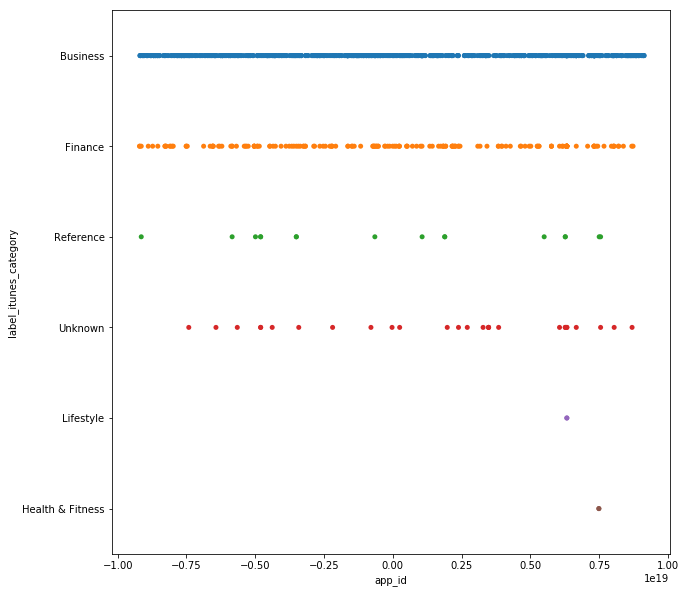

In [45]:
dimensions = (10, 10)
fig, ax = pyplot.subplots(figsize=dimensions)
sns.stripplot(x="app_id", y="label_itunes_category", data=app_labels_pandas);

### Data Transformation

In [46]:
combined_data_df = pd.merge(phone_brand_device_model, gender_age_train, left_on='device_id', right_on='device_id')

In [47]:
combined_data_df = pd.merge(combined_data_df, events, left_on='device_id', right_on='device_id')

In [48]:
combined_data_df = pd.merge(combined_data_df, app_events, left_on='event_id', right_on='event_id')

In [49]:
combined_data_df = pd.merge(combined_data_df, app_labels, left_on='app_id', right_on='app_id')

In [50]:
combined_data_df = pd.merge(combined_data_df, label_categories, left_on='label_itunes_category', right_on='label_itunes_category')

In [51]:
combined_data_df.head()

,device_id,phone_brand,device_model,gender,age,group,event_id,timestamp,longitude,latitude,app_id,is_installed,is_active,category_x,label_itunes_category,label_id,category_y
0,-3352337094847398864,OPPO,R7,M,21,M22-,22635,2016-05-06 19:27:52,0.0,0.0,5927333115845830913,1,1,Property Industry 1.0,Business,69,business
1,-3352337094847398864,OPPO,R7,M,21,M22-,22635,2016-05-06 19:27:52,0.0,0.0,5927333115845830913,1,1,Property Industry 1.0,Business,216,Business Office
2,-3352337094847398864,OPPO,R7,M,21,M22-,22635,2016-05-06 19:27:52,0.0,0.0,5927333115845830913,1,1,Property Industry 1.0,Business,228,work
3,-3352337094847398864,OPPO,R7,M,21,M22-,22635,2016-05-06 19:27:52,0.0,0.0,5927333115845830913,1,1,Property Industry 1.0,Business,229,Jobs
4,-3352337094847398864,OPPO,R7,M,21,M22-,22635,2016-05-06 19:27:52,0.0,0.0,5927333115845830913,1,1,Property Industry 1.0,Business,237,store management


In [52]:
combined_data_df.shape

(34848, 17)

M    28869
F     5979
Name: gender, dtype: int64


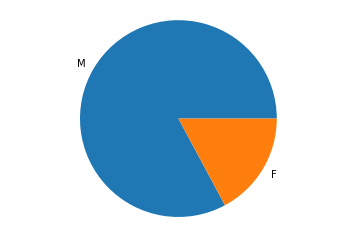

In [53]:
counts = combined_data_df.gender.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

In [54]:
dummy = pd.get_dummies(combined_data_df) # Transform the categorical variables into binary vectors

In [55]:
pd.set_option('display.max_columns', 10)

In [56]:
dummy.head()

,device_id,age,event_id,longitude,latitude,...,category_y_unknown,category_y_vitality,category_y_wallet,category_y_wig,category_y_work
0,-3352337094847398864,21,22635,0.0,0.0,...,0,0,0,0,0
1,-3352337094847398864,21,22635,0.0,0.0,...,0,0,0,0,0
2,-3352337094847398864,21,22635,0.0,0.0,...,0,0,0,0,1
3,-3352337094847398864,21,22635,0.0,0.0,...,0,0,0,0,0
4,-3352337094847398864,21,22635,0.0,0.0,...,0,0,0,0,0


In [57]:
features = dummy.drop(['gender_F', 'gender_M', 'age'], axis=1).columns

In [58]:
X = dummy[features]
Y = dummy['gender_F']
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [59]:
print("normal data distribution: {}".format(Counter(Y_train)))

normal data distribution: Counter({0: 23067, 1: 4811})


0    23067
1     4811
Name: gender_F, dtype: int64


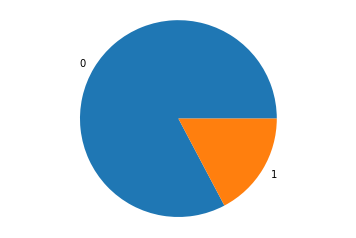

In [60]:
counts = Y_train.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

In [61]:
sm = SMOTE(random_state=12, ratio=1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [62]:
print("SMOTE data distribution: {}".format(Counter(Y_train)))

SMOTE data distribution: Counter({0: 23067, 1: 23067})


### Training and testing with GridSearchCV

#### Logistic Regression (Classification L2)

In [63]:
log_reg_model = linear_model.LogisticRegression(penalty = 'l2')

In [64]:
# Define the parameter values that should be searched# Define 
C = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [65]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C)
print(param_grid)

{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


In [66]:
# instantiate and fit the grid
grid = GridSearchCV(log_reg_model, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [67]:
# Logistic Regression
start = time.time()
grid.fit(X_train, Y_train)
log_reg_pred = grid.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 17.81


In [68]:
# View the complete results
grid.grid_scores_

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.58118, std: 0.00738, params: {'C': 0.001},
 mean: 0.58118, std: 0.00738, params: {'C': 0.01},
 mean: 0.58118, std: 0.00738, params: {'C': 0.1},
 mean: 0.58118, std: 0.00738, params: {'C': 1},
 mean: 0.58118, std: 0.00738, params: {'C': 10},
 mean: 0.58118, std: 0.00738, params: {'C': 100},
 mean: 0.58118, std: 0.00738, params: {'C': 1000}]

In [69]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.581176572593
{'C': 0.001}


In [70]:
log_reg_model = linear_model.LogisticRegression(penalty = 'l2', C=1)
log_reg_model.fit(X_train, Y_train)
log_reg_pred = log_reg_model.predict(X_train)

             precision    recall  f1-score   support

   Churn_No       0.56      0.80      0.66     23067
  Churn_Yes       0.64      0.37      0.47     23067

avg / total       0.60      0.58      0.56     46134



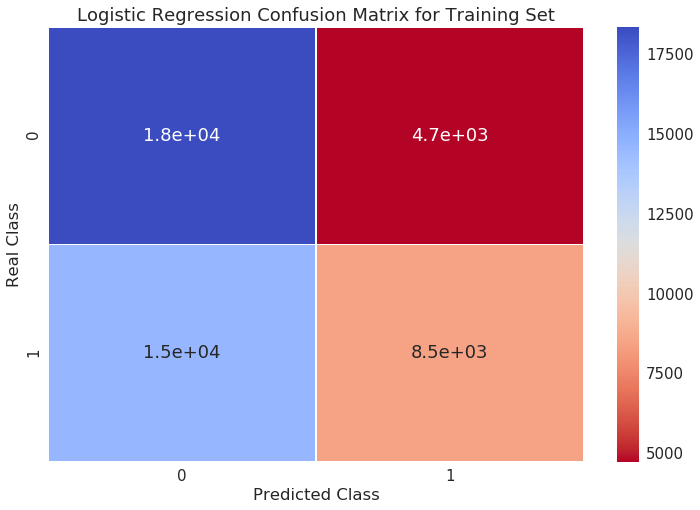

Cross Validation Accuracy Scores: 0.581(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.755(+/- 0.02)


In [71]:
# Printing classification report
print(classification_report(Y_train, log_reg_pred, target_names=['Churn_No', 'Churn_Yes']))

# Building confusion matrix
conf_matrix_train_logR = confusion_matrix(Y_train, log_reg_pred)

#creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.facecolor':'#757575ff', 'figure.facecolor':'#757575ff', 'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1.5)
sns.heatmap(conf_matrix_train_logR,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Logistic Regression Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_logR = cross_val_score(log_reg_model, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_logR.mean(), scores_logR.std()*2))

scores_logRTest = cross_val_score(log_reg_model, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_logRTest.mean(), scores_logRTest.std()*2))

#### Ridge

In [72]:
rclass = RidgeClassifier()

In [73]:
# Define the parameter values that should be searched# Define 
param_grid = {'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}

In [74]:
# Ridge Classifier
start = time.time()
grid = GridSearchCV(rclass, param_grid, verbose=1, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)
Y_pred_rclass = grid.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  2.5min finished


Runtime 153.65


In [75]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

1.0
{'alpha': 25}


In [76]:
rclass = RidgeClassifier(alpha=0.8)
rclass.fit(X_train, Y_train)
Y_pred_rclass = rclass.predict(X_train)

             precision    recall  f1-score   support

   Churn_No       1.00      1.00      1.00     23067
  Churn_Yes       1.00      1.00      1.00     23067

avg / total       1.00      1.00      1.00     46134



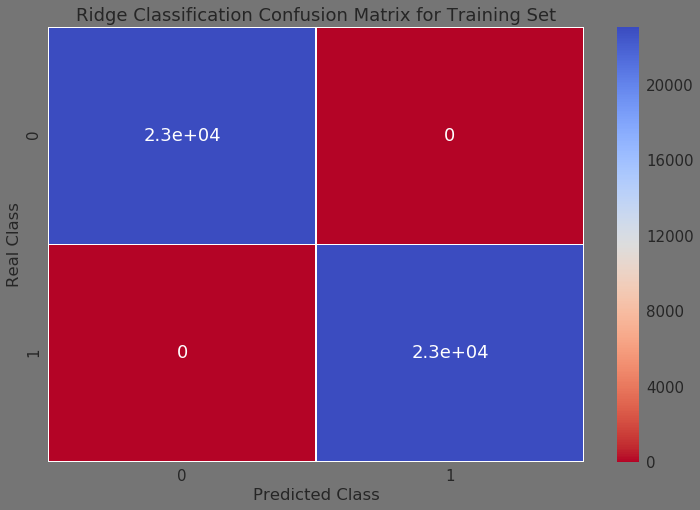

Cross Validation Accuracy Scores: 1.000(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 1.000(+/- 0.00)


In [77]:
# Print classification report
print(classification_report(Y_train, Y_pred_rclass, target_names=['Churn_No', 'Churn_Yes']))

# Building confusion matrix
conf_matrix_rclass = confusion_matrix(Y_train, Y_pred_rclass)

# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.facecolor':'#757575ff', 'figure.facecolor':'#757575ff', 'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1.5)
sns.heatmap(conf_matrix_rclass, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Ridge Classification Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_rclass = cross_val_score(rclass, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rclass.mean(), scores_rclass.std()*2))

scores_rclassTest = cross_val_score(rclass, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_rclassTest.mean(), scores_rclassTest.std()*2))

### Training and testing applying PCA

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [79]:
# Standardize the feature matrix
X = StandardScaler().fit_transform(X_train)

In [80]:
# Create a PCA that will retain 90% of the variance
pca = PCA(n_components=0.75, whiten=True)

# Conduct PCA
X_pca = pca.fit_transform(X)

In [81]:
# Show results
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 589
Reduced number of features: 375


In [82]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = Y_train)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

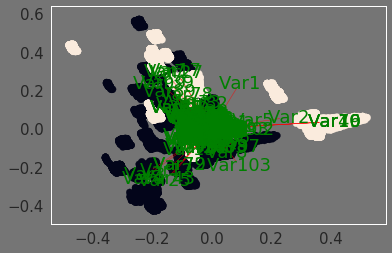

In [83]:
#Call the function. Use only the 2 PCs.
myplot(X_pca[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [84]:
from sklearn.pipeline import Pipeline

#### Logistic Regression (L2)

In [85]:
pipe = Pipeline([('pca', pca), ('logistic', log_reg_model)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

In [86]:
# Printing classification report
print(classification_report(Y_train, pred, target_names=['Churn_No', 'Churn_Yes']))

scores = cross_val_score(pipe, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   Churn_No       0.65      0.68      0.66     23067
  Churn_Yes       0.66      0.63      0.65     23067

avg / total       0.65      0.65      0.65     46134

Cross Validation Accuracy Scores: 0.654(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.832(+/- 0.00)


#### Ridge

In [87]:
pipe = Pipeline([('pca', pca), ('rclass', rclass)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

In [88]:
# Printing classification report# Printin 
print(classification_report(Y_train, pred, target_names=['Churn_No', 'Churn_Yes']))

scores = cross_val_score(pipe, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

scores_T = cross_val_score(pipe, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_T.mean(), scores_T.std()*2))

             precision    recall  f1-score   support

   Churn_No       0.58      0.68      0.62     23067
  Churn_Yes       0.61      0.51      0.56     23067

avg / total       0.60      0.59      0.59     46134

Cross Validation Accuracy Scores: 0.594(+/- 0.02)
Cross Validation Accuracy Scores - Test Set: 0.832(+/- 0.00)


In [89]:
X_validation.shape, Y_validation.shape


((6970, 589), (6970,))

### Running Neural Networks models

In [90]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD

# Import the backend
from keras import backend as K

Using TensorFlow backend.


In [92]:
X_train, X_test = X_train, X_validation
Y_train, Y_test = Y_train, Y_validation

#Normalize color values to between 0 and 1
X_train = X_train/255
X_test = X_test/255

#Reshaping to a flattened version
#X_flat_train = X_train.reshape(X_train.shape[0], 10*10*3)
#X_flat_test = X_test.reshape(X_test.shape[0], 10*10*3)

#Encoding the output
Y_train = keras.utils.to_categorical(Y_train, 60)
Y_test = keras.utils.to_categorical(Y_test, 60)

print('Original Sizes:', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Flattened:', X_train.shape, X_test.shape)

Original Sizes: (46134, 589) (6970, 589) (46134, 60, 60) (6970, 60)
Flattened: (46134, 589) (6970, 589)


1. Multi Layer Perceptron

We will start with a simple sequential model using two dense layers of 128 nodes and 64 nodes respectively with a Rectified Linear Unit activation funcion.

In [93]:
model_dense = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_dense.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
# Dropout layers remove features and fight overfitting
model_dense.add(Dropout(0.1))
model_dense.add(Dense(64, activation='relu'))
model_dense.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model_dense.add(Dense(60, activation='softmax'))

model_dense.summary()

# Compile the model to put it all together.
model_dense.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_dense = model_dense.fit(X_train, Y_train,
                          batch_size=128,
                          epochs=10,
                          verbose=1,
                          validation_data=(X_validation, Y_validation))
score = model_dense.evaluate(X_validation, Y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               75520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3900      
Total params: 87,676
Trainable params: 87,676
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking target: expected dense_3 to have 2 dimensions, but got array with shape (46134, 60, 60)

2. Convolutional Neural Network

In [94]:
model_cnn = Sequential()
# First convolutional layer, note the specification of shape
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(45, 45, 3)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(60, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (46134, 589)